# AMLB shorter runs visualizations

In [1]:
import itertools
import math
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn


In [2]:
from data_processing import get_print_friendly_name, impute_missing_results, calculate_ranks, add_rescale, is_old
from visualization_early import FRAMEWORK_TO_COLOR

In [3]:
def impute_results(results: pd.DataFrame, where: pd.Series, with_: str = "constantpredictor", indicator_column: str = "imputed") -> pd.DataFrame:
    """Impute result column of `results`, `where_` a condition holds true, `with_` the result of another framework.

    results: pd.DataFrame
      Regular AMLB results dataframe, must have columns "framework", "task", "fold", "constraint", and "result".
    where: pd.Series
      A logical index into `results` that defines the row where "result" should be imputed.
    with_: str
      The name of the "framework" which should be used to determine the value to impute with.
    indicator_column: str, optional
      The name of the column where a boolean will mark whether or not the "result" value of the row was imputed.
    
    Returns a copy of the original dataframe with imputed results.
    """
    if with_ not in results["framework"].unique():
        raise ValueError(f"{with_=} is not in `results`")
    results = results.copy()
    
    if indicator_column and indicator_column not in results.columns:
        results[indicator_column] = False
        
    lookup_table = results.set_index(["framework", "task", "fold", "constraint"])
    for index, row in results[where].iterrows():
        task, fold, constraint = row[["task", "fold", "constraint"]]
        results.loc[index, "result"] = lookup_table.loc[(with_, task, fold, constraint)].result 
        if indicator_column:
            results.loc[index, indicator_column] = True
    return results

In [4]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures"  / "regret"

for subfolder in ["pareto_performance_inference", "pareto_performance_training", "pareto_training_inference"]:
    (FIGURE_DIRECTORY / subfolder).mkdir(parents=True, exist_ok=True)

In [5]:
results_not_early = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})

In [6]:
results_early = pd.read_csv(DATA_DIRECTORY / "amlb_all_early.csv", dtype={"info": str})

In [7]:
import pandas as pd

results_combined = pd.concat([results_not_early, results_early])

# Define the list of frameworks to keep
frameworks_to_keep = ['AutoGluon_benchmark', 'AutoGluon_HQIL', 'AutoGluon_HQ', 'FEDOT', 'H2OAutoML', 'TPOT', 'flaml', 'RandomForest_60min', 'TunedRandomForest_60min', 'constantpredictor_60min']
# AutoGluon_FI_FT_IL

# Filter the dataframe
results = results_combined[results_combined['framework'].str.contains('|'.join(frameworks_to_keep))]
results["framework"] = results["framework"].apply(get_print_friendly_name)

C:\Users\20210595\AppData\Local\Temp\ipykernel_36444\12352355.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["framework"] = results["framework"].apply(get_print_friendly_name)


In [8]:
results = impute_results(
    results,
    where=results["result"].isna(),
    with_="CP_60min",
)

In [9]:
# Assuming 'results' is your DataFrame and it contains the 'training_duration' column
mean_results = results[["framework", "task", "constraint", "metric", "result", "imputed", "infer_batch_size_file_10000", "training_duration"]].groupby(
    ["framework", "task", "constraint", "metric"], as_index=False).agg(
    {"result": "mean", "infer_batch_size_file_10000": "mean", "imputed": "sum", "training_duration": "mean"}
)

lookup = mean_results.set_index(["framework", "task", "constraint"])

for index, row in mean_results.iterrows():
    lower = lookup.loc[("RF_60min", row["task"], row["constraint"]), "result"]
    upper = lookup.loc[(slice(None), row["task"], row["constraint"]), "result"].max()
    if lower == upper:
        mean_results.loc[index, "scaled"] = float("nan")
    else:
        mean_results.loc[index, "scaled"] = (row["result"] - lower) / (upper - lower)


In [10]:
dataframe_with_without_early = pd.DataFrame()
dataframe_with_without_early['framework'] = []
dataframe_with_without_early['task'] = []
dataframe_with_without_early['Performance with'] = []
dataframe_with_without_early['Performance without'] = []
dataframe_with_without_early['Original time'] = []
dataframe_with_without_early['Training duration'] = []
dataframe_with_without_early['Early training duration'] = []

filtered_results_original = mean_results[mean_results['framework'].str.contains('TPOT', na=False)]

for times in ['5min', '10min', '30min', '60min']:
    filtered_results = filtered_results_original[filtered_results_original['framework'].str.contains(times, na=False)]
    filtered_results_with_e = filtered_results[filtered_results['framework'].str.contains("_E", na=False)]
    filtered_results_with_e = filtered_results_with_e.sort_values(by='task')
    filtered_results_without_e = filtered_results[~filtered_results['framework'].str.contains("_E", na=False)]
    filtered_results_without_e = filtered_results_without_e.sort_values(by='task')
    
    
    name_framework = filtered_results_without_e.framework.unique()
    name_framework = name_framework[0].replace(f"_{times}", "")
    framework_list =  [name_framework for h in range(len(filtered_results_with_e))]
    if times == "5min":
        original_time = [300 for h in range(len(filtered_results_with_e))]
    elif times == "10min":
        original_time = [600 for h in range(len(filtered_results_with_e))]
    elif times == "30min":
        original_time = [1800 for h in range(len(filtered_results_with_e))]
    elif times == "60min":
        original_time = [3600 for h in range(len(filtered_results_with_e))]
    extra_data = {
        'framework': framework_list,
        'task': filtered_results_with_e['task'].tolist(),
        'Performance with': filtered_results_with_e['scaled'].tolist(),
        'Performance without': filtered_results_without_e['scaled'].tolist(),
        'Original time': original_time,
        'Training duration': filtered_results_without_e['training_duration'].tolist(),
        'Early training duration': filtered_results_with_e['training_duration'].tolist()
    }
    df_extra = pd.DataFrame(extra_data)
    
    # Step 3: Concatenate the new DataFrame with the existing DataFrame
    dataframe_with_without_early = pd.concat([dataframe_with_without_early, df_extra], ignore_index=True)

In [11]:
# Escape the parentheses in the search string
search_string = ['AutoGluon\\(B\\)', 'AutoGluon\\(HQ\\)', 'AutoGluon\\(HQIL\\)', 
                 'FEDOT', 'flaml', 'H2OAutoML', 'TPOT',
                ]

dataframe_with_without_early = pd.DataFrame()

dataframe_with_without_early['framework'] = []
dataframe_with_without_early['task'] = []
dataframe_with_without_early['Performance with'] = []
dataframe_with_without_early['Performance without'] = []
dataframe_with_without_early['Original time'] = []
dataframe_with_without_early['Training duration'] = []
dataframe_with_without_early['Early training duration'] = []

for this_framework in search_string:
# Filter the DataFrame, handling NaN values
    print("framework", this_framework)
    filtered_results_original = mean_results[mean_results['framework'].str.contains(this_framework, na=False)]  
    for times in ['5min', '10min', '30min', '60min']:
        filtered_results = filtered_results_original[filtered_results_original['framework'].str.contains(times, na=False)]
        filtered_results_with_e = filtered_results[filtered_results['framework'].str.contains("_E", na=False)]
        filtered_results_with_e = filtered_results_with_e.sort_values(by='task')
        filtered_results_without_e = filtered_results[~filtered_results['framework'].str.contains("_E", na=False)]
        filtered_results_without_e = filtered_results_without_e.sort_values(by='task')
        
        
        name_framework = filtered_results_without_e.framework.unique()
        name_framework = name_framework[0].replace(f"_{times}", "")
        print("name to add", name_framework, times)
        framework_list =  [name_framework for h in range(len(filtered_results_with_e))]
        if times == "5min":
            original_time = [300 for h in range(len(filtered_results_with_e))]
        elif times == "10min":
            original_time = [600 for h in range(len(filtered_results_with_e))]
        elif times == "30min":
            original_time = [1800 for h in range(len(filtered_results_with_e))]
        elif times == "60min":
            original_time = [3600 for h in range(len(filtered_results_with_e))]
        extra_data = {
            'framework': framework_list,
            'task': filtered_results_with_e['task'].tolist(),
            'Performance with': filtered_results_with_e['result'].tolist(),
            'Performance without': filtered_results_without_e['result'].tolist(),
            'Original time': original_time,
            'Training duration': filtered_results_without_e['training_duration'].tolist(),
            'Early training duration': filtered_results_with_e['training_duration'].tolist()
        }
        df_extra = pd.DataFrame(extra_data)
        
        # Step 3: Concatenate the new DataFrame with the existing DataFrame
        dataframe_with_without_early = pd.concat([dataframe_with_without_early, df_extra], ignore_index=True)
        

framework AutoGluon\(B\)
name to add AutoGluon(B) 5min
name to add AutoGluon(B) 10min
name to add AutoGluon(B) 30min
name to add AutoGluon(B) 60min
framework AutoGluon\(HQ\)
name to add AutoGluon(HQ) 5min
name to add AutoGluon(HQ) 10min
name to add AutoGluon(HQ) 30min
name to add AutoGluon(HQ) 60min
framework AutoGluon\(HQIL\)
name to add AutoGluon(HQIL) 5min
name to add AutoGluon(HQIL) 10min
name to add AutoGluon(HQIL) 30min
name to add AutoGluon(HQIL) 60min
framework FEDOT
name to add FEDOT 5min
name to add FEDOT 10min
name to add FEDOT 30min
name to add FEDOT 60min
framework flaml
name to add flaml 5min
name to add flaml 10min
name to add flaml 30min
name to add flaml 60min
framework H2OAutoML
name to add H2OAutoML 5min
name to add H2OAutoML 10min
name to add H2OAutoML 30min
name to add H2OAutoML 60min
framework TPOT
name to add TPOT 5min
name to add TPOT 10min
name to add TPOT 30min
name to add TPOT 60min


In [12]:
# Step 1: Calculate the "regret" column
dataframe_with_without_early['regret'] = dataframe_with_without_early['Performance without'] - dataframe_with_without_early['Performance with']

# Step 2: Calculate the "delta time" column
dataframe_with_without_early['delta time'] = dataframe_with_without_early['Training duration'] - dataframe_with_without_early['Early training duration']
dataframe_with_without_early

,framework,task,Performance with,Performance without,Original time,Training duration,Early training duration,regret,delta time
0,AutoGluon(B),APSFailure,0.993256,0.993218,300.0,312.22,307.800000,-0.000038,4.420000
1,AutoGluon(B),Airlines_DepDelay_10M,-28.825720,-28.815520,300.0,304.17,305.510000,0.010200,-1.340000
2,AutoGluon(B),Allstate_Claims_Severity,-1879.531000,-1879.521000,300.0,344.62,360.850000,0.010000,-16.230000
3,AutoGluon(B),Amazon_employee_access,0.898274,0.901070,300.0,304.45,300.260000,0.002796,4.190000
4,AutoGluon(B),Australian,0.938921,0.942161,300.0,301.54,243.920000,0.003241,57.620000
...,...,...,...,...,...,...,...,...,...
2907,TPOT,wilt,0.844146,0.995914,3600.0,3646.81,793.240000,0.151768,2853.570000
2908,TPOT,wine-quality-white,-1.078244,-1.043598,3600.0,3669.56,1952.940000,0.034646,1716.620000
2909,TPOT,wine_quality,-0.579515,-0.576662,3600.0,3315.47,1758.140000,0.002853,1557.330000
2910,TPOT,yeast,-1.393897,-1.397718,3600.0,2226.82,582.180000,-0.003820,1644.640000


In [13]:
def dataset_imbalanced(dataset_qualities, threshold=1.5):
    """
    Determine if the dataset is imbalanced based on the given threshold.
    
    Parameters:
    - dataset_qualities (dict): Dictionary containing dataset qualities.
    - threshold (float): Threshold for determining imbalance. Default is 1.5.
    
    Returns:
    - bool: True if the dataset is imbalanced, False otherwise.
    """
    majority_class_percentage = dataset_qualities.get('MajorityClassPercentage')
    minority_class_percentage = dataset_qualities.get('MinorityClassPercentage')
    
    if majority_class_percentage is None or minority_class_percentage is None:
        raise ValueError("MajorityClassPercentage or MinorityClassPercentage is missing in dataset qualities.")

    # Calculate the imbalance ratio
    imbalance_ratio = float(minority_class_percentage / majority_class_percentage)
    
    # Determine if the dataset is imbalanced
    return round(imbalance_ratio, 2)
    
    # # Calculate the imbalance ratio
    # imbalance_ratio = majority_class_percentage / minority_class_percentage
    
    # # Determine if the dataset is imbalanced
    # return imbalance_ratio > threshold

In [14]:
import openml
from openml.tasks import OpenMLRegressionTask

In [15]:
ids_string = results.id.unique()
# ids = [element.replace("openml.org/t/", "") for element in ids_string]
list_binary = []
list_multiclass = []
list_regression = []
percentage_numeric_feature = []
imbalance_dataset = []
balance_dataset = []
dataset_ids = dict()
dataset_ids_instances = dict()
dataset_ids_features = dict()
dataset_n_classes = dict()
dataset_ratio = dict()
for task_id in results.id.unique():
    name_task = results[results['id']==task_id].task.unique()[0]
    task_id = task_id.replace("openml.org/t/", "")
    task = openml.tasks.get_task(task_id)
    # if task.PercentageOfNumericFeatures >50:
    #    percentage_numeric_feature.append(name_task)
    dataset_id = task.dataset_id
    dataset = openml.datasets.get_dataset(dataset_id, download_data = False)
    dataset_ids[name_task] = dataset_id
    dataset_ids_instances[name_task] = dataset.qualities['NumberOfInstances']
    dataset_ids_features[name_task] = dataset.qualities['NumberOfFeatures']
    if isinstance(task, OpenMLRegressionTask):
        list_regression.append(name_task)
        dataset_n_classes[name_task] = float('nan')
        dataset_ratio[name_task] = float('nan')
    else:
        dataset_n_classes[name_task] = len(task.class_labels)
        dataset_ratio[name_task] = dataset_imbalanced(dataset.qualities)
        if len(task.class_labels) == 2:
            list_binary.append(name_task)
        else:
            list_multiclass.append(name_task)

C:\Users\20210595\.conda\envs\visualize_5\lib\site-packages\IPython\core\interactiveshell.py:3550: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\20210595\.conda\envs\visualize_5\lib\site-packages\IPython\core\interactiveshell.py:3550: FutureWarning: Task id must be specified as `int` from 0.14.0 onwards.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\20210595\.conda\envs\visualize_5\lib\site-packages\openml\tasks\functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `downlo

In [16]:
dataframe_with_without_early['Features'] = dataframe_with_without_early['task'].map(dataset_ids_features)
dataframe_with_without_early['Instances'] = dataframe_with_without_early['task'].map(dataset_ids_instances)
dataframe_with_without_early['Ratio'] = dataframe_with_without_early['task'].map(dataset_ratio)
dataframe_with_without_early['Classes'] = dataframe_with_without_early['task'].map(dataset_n_classes)
dataframe_with_without_early

,framework,task,Performance with,Performance without,Original time,Training duration,Early training duration,regret,delta time,Features,Instances,Ratio,Classes
0,AutoGluon(B),APSFailure,0.993256,0.993218,300.0,312.22,307.800000,-0.000038,4.420000,171.0,76000.0,0.02,2.0
1,AutoGluon(B),Airlines_DepDelay_10M,-28.825720,-28.815520,300.0,304.17,305.510000,0.010200,-1.340000,10.0,10000000.0,NaN,NaN
2,AutoGluon(B),Allstate_Claims_Severity,-1879.531000,-1879.521000,300.0,344.62,360.850000,0.010000,-16.230000,131.0,188318.0,NaN,NaN
3,AutoGluon(B),Amazon_employee_access,0.898274,0.901070,300.0,304.45,300.260000,0.002796,4.190000,10.0,32769.0,0.06,2.0
4,AutoGluon(B),Australian,0.938921,0.942161,300.0,301.54,243.920000,0.003241,57.620000,15.0,690.0,0.80,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,TPOT,wilt,0.844146,0.995914,3600.0,3646.81,793.240000,0.151768,2853.570000,6.0,4839.0,0.06,2.0
2908,TPOT,wine-quality-white,-1.078244,-1.043598,3600.0,3669.56,1952.940000,0.034646,1716.620000,12.0,4898.0,0.00,7.0
2909,TPOT,wine_quality,-0.579515,-0.576662,3600.0,3315.47,1758.140000,0.002853,1557.330000,12.0,6497.0,NaN,NaN
2910,TPOT,yeast,-1.393897,-1.397718,3600.0,2226.82,582.180000,-0.003820,1644.640000,9.0,1484.0,0.01,10.0


In [17]:
# Define the function to determine the size
def determine_size(instances):
    if instances < 100000:
        return 20
    elif instances < 1000000:
        return 40
    elif instances < 5000000:
        return 60
    else:
        return 80

In [18]:
# Apply the function to create the new 'size' column
dataframe_with_without_early['size'] = dataframe_with_without_early['Instances'].apply(determine_size)
dataframe_with_without_early

,framework,task,Performance with,Performance without,Original time,Training duration,Early training duration,regret,delta time,Features,Instances,Ratio,Classes,size
0,AutoGluon(B),APSFailure,0.993256,0.993218,300.0,312.22,307.800000,-0.000038,4.420000,171.0,76000.0,0.02,2.0,20
1,AutoGluon(B),Airlines_DepDelay_10M,-28.825720,-28.815520,300.0,304.17,305.510000,0.010200,-1.340000,10.0,10000000.0,NaN,NaN,80
2,AutoGluon(B),Allstate_Claims_Severity,-1879.531000,-1879.521000,300.0,344.62,360.850000,0.010000,-16.230000,131.0,188318.0,NaN,NaN,40
3,AutoGluon(B),Amazon_employee_access,0.898274,0.901070,300.0,304.45,300.260000,0.002796,4.190000,10.0,32769.0,0.06,2.0,20
4,AutoGluon(B),Australian,0.938921,0.942161,300.0,301.54,243.920000,0.003241,57.620000,15.0,690.0,0.80,2.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,TPOT,wilt,0.844146,0.995914,3600.0,3646.81,793.240000,0.151768,2853.570000,6.0,4839.0,0.06,2.0,20
2908,TPOT,wine-quality-white,-1.078244,-1.043598,3600.0,3669.56,1952.940000,0.034646,1716.620000,12.0,4898.0,0.00,7.0,20
2909,TPOT,wine_quality,-0.579515,-0.576662,3600.0,3315.47,1758.140000,0.002853,1557.330000,12.0,6497.0,NaN,NaN,20
2910,TPOT,yeast,-1.393897,-1.397718,3600.0,2226.82,582.180000,-0.003820,1644.640000,9.0,1484.0,0.01,10.0,20


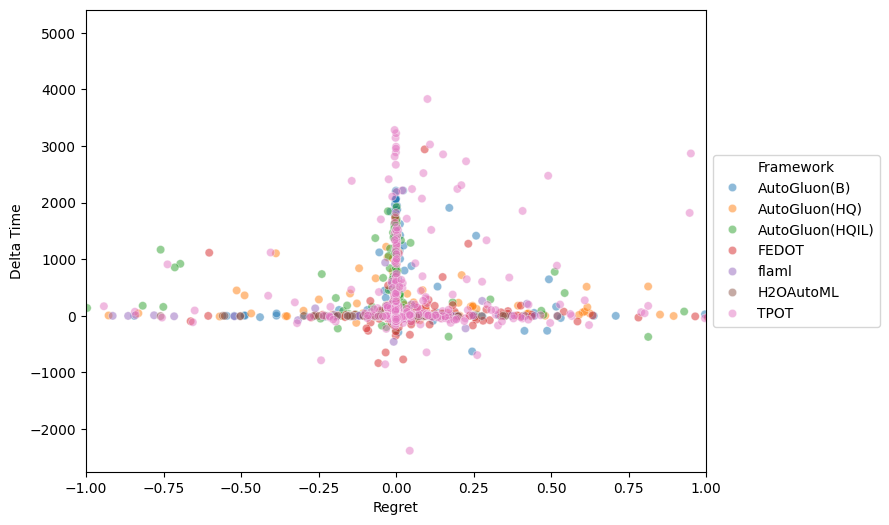

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='regret', y='delta time', hue='framework', data=dataframe_with_without_early, alpha=0.5)

# Set limits for the x-axis
plt.xlim(-1, 1)

# Add title and labels
# plt.title('Scatter Plot of Regret vs Delta Time')
plt.xlabel('Regret')
plt.ylabel('Delta Time')

# Add legend outside the plot
plt.legend(title='Framework', loc='center left', bbox_to_anchor=(1, 0.5))

# Save the plot
plt.savefig(FIGURE_DIRECTORY / 'regret_delta_general.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

#### With outliers log scale and size of datasets

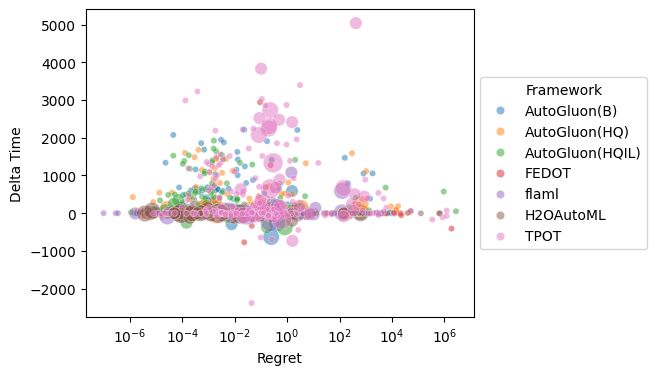

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of frameworks to keep in the legend
frameworks_to_keep = [
    'AutoGluon(B)',
    'AutoGluon(HQ)',
    'AutoGluon(HQIL)',
    'FEDOT',
    'flaml',
    'H2OAutoML',
    'TPOT'
]

# Create the scatter plot
plt.figure(figsize=(5, 4))
scatter_plot = sns.scatterplot(x='regret', y='delta time', hue='framework', size='size', data=dataframe_with_without_early, alpha=0.5, sizes=(20, 200))

# Add title and labels
# plt.title('Scatter Plot of Regret vs Delta Time')
plt.xlabel('Regret')
plt.ylabel('Delta Time')

plt.xscale('log')
# plt.yscale('log')

# Customize the legend to keep only the specified frameworks
handles, labels = scatter_plot.get_legend_handles_labels()
filtered_handles_labels = [(handle, label) for handle, label in zip(handles, labels) if label in frameworks_to_keep]

# Add the customized legend outside the plot
scatter_plot.legend(*zip(*filtered_handles_labels), title='Framework', loc='center left', bbox_to_anchor=(1, 0.5))

# Save the plot
plt.savefig(FIGURE_DIRECTORY / 'regret_delta_general_outliers.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

#### With constraints log scale and size of dataset

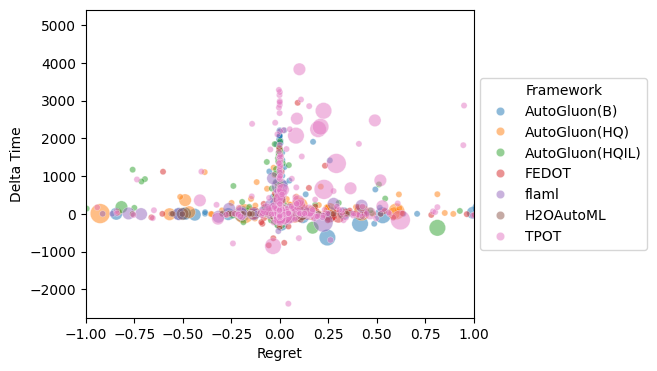

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of frameworks to keep in the legend
frameworks_to_keep = [
    'AutoGluon(B)',
    'AutoGluon(HQ)',
    'AutoGluon(HQIL)',
    'FEDOT',
    'flaml',
    'H2OAutoML',
    'TPOT'
]

# Create the scatter plot
plt.figure(figsize=(5, 4))
scatter_plot = sns.scatterplot(x='regret', y='delta time', hue='framework', size='size', data=dataframe_with_without_early, alpha=0.5, sizes=(20, 200))

# Set limits for the x-axis
plt.xlim(-1, 1)

# Add title and labels
# plt.title('Scatter Plot of Regret vs Delta Time')
plt.xlabel('Regret')
plt.ylabel('Delta Time')

# Customize the legend to keep only the specified frameworks
handles, labels = scatter_plot.get_legend_handles_labels()
filtered_handles_labels = [(handle, label) for handle, label in zip(handles, labels) if label in frameworks_to_keep]

# Add the customized legend outside the plot
scatter_plot.legend(*zip(*filtered_handles_labels), title='Framework', loc='center left', bbox_to_anchor=(1, 0.5))

# Save the plot
plt.savefig(FIGURE_DIRECTORY / 'regret_delta_general.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

### Which tasks have higher regret?

In [22]:
filtered_df_regret = dataframe_with_without_early[dataframe_with_without_early['regret'] > 0.5]

# Group by framework and collect tasks into sets
framework_tasks = filtered_df_regret.groupby('framework')['task'].apply(set)

# Find the intersection of tasks among all frameworks
intersection_tasks = set.intersection(*framework_tasks)

# Display the result
print(intersection_tasks)

{'house_sales', 'diamonds', 'house_prices_nominal', 'house_16H', 'MIP-2016-regression'}


In [23]:
filtered_df_regret.columns

Index(['framework', 'task', 'Performance with', 'Performance without',
       'Original time', 'Training duration', 'Early training duration',
       'regret', 'delta time', 'Features', 'Instances', 'Ratio', 'Classes',
       'size'],
      dtype='object')

In [24]:
# Find the union of tasks among all frameworks
union_tasks = set.union(*framework_tasks)

# Display the result
print(union_tasks)

{'colleges', 'Moneyball', 'Yolanda', 'credit-g', 'amazon-commerce-reviews', 'Buzzinsocialmedia_Twitter', 'Amazon_employee_access', 'nyc-taxi-green-dec-2016', 'Satellite', 'KDDCup99', 'black_friday', 'boston', 'jungle_chess_2pcs_raw_endgame_complete', 'cnae-9', 'abalone', 'OnlineNewsPopularity', 'Fashion-MNIST', 'diamonds', 'QSAR-TID-11', 'dilbert', 'philippine', 'jannis', 'Diabetes130US', 'Higgs', 'house_16H', 'MIP-2016-regression', 'SAT11-HAND-runtime-regression', 'christine', 'micro-mass', 'churn', 'Brazilian_houses', 'robert', 'socmob', 'dionis', 'GesturePhaseSegmentationProcessed', 'house_sales', 'Allstate_Claims_Severity', 'sensory', 'helena', 'covertype', 'Mercedes_Benz_Greener_Manufacturing', 'tecator', 'car', 'guillermo', 'kc1', 'Airlines_DepDelay_10M', 'kr-vs-kp', 'dna', 'Santander_transaction_value', 'topo_2_1', 'quake', 'segment', 'yeast', 'house_prices_nominal', 'Australian', 'pol'}


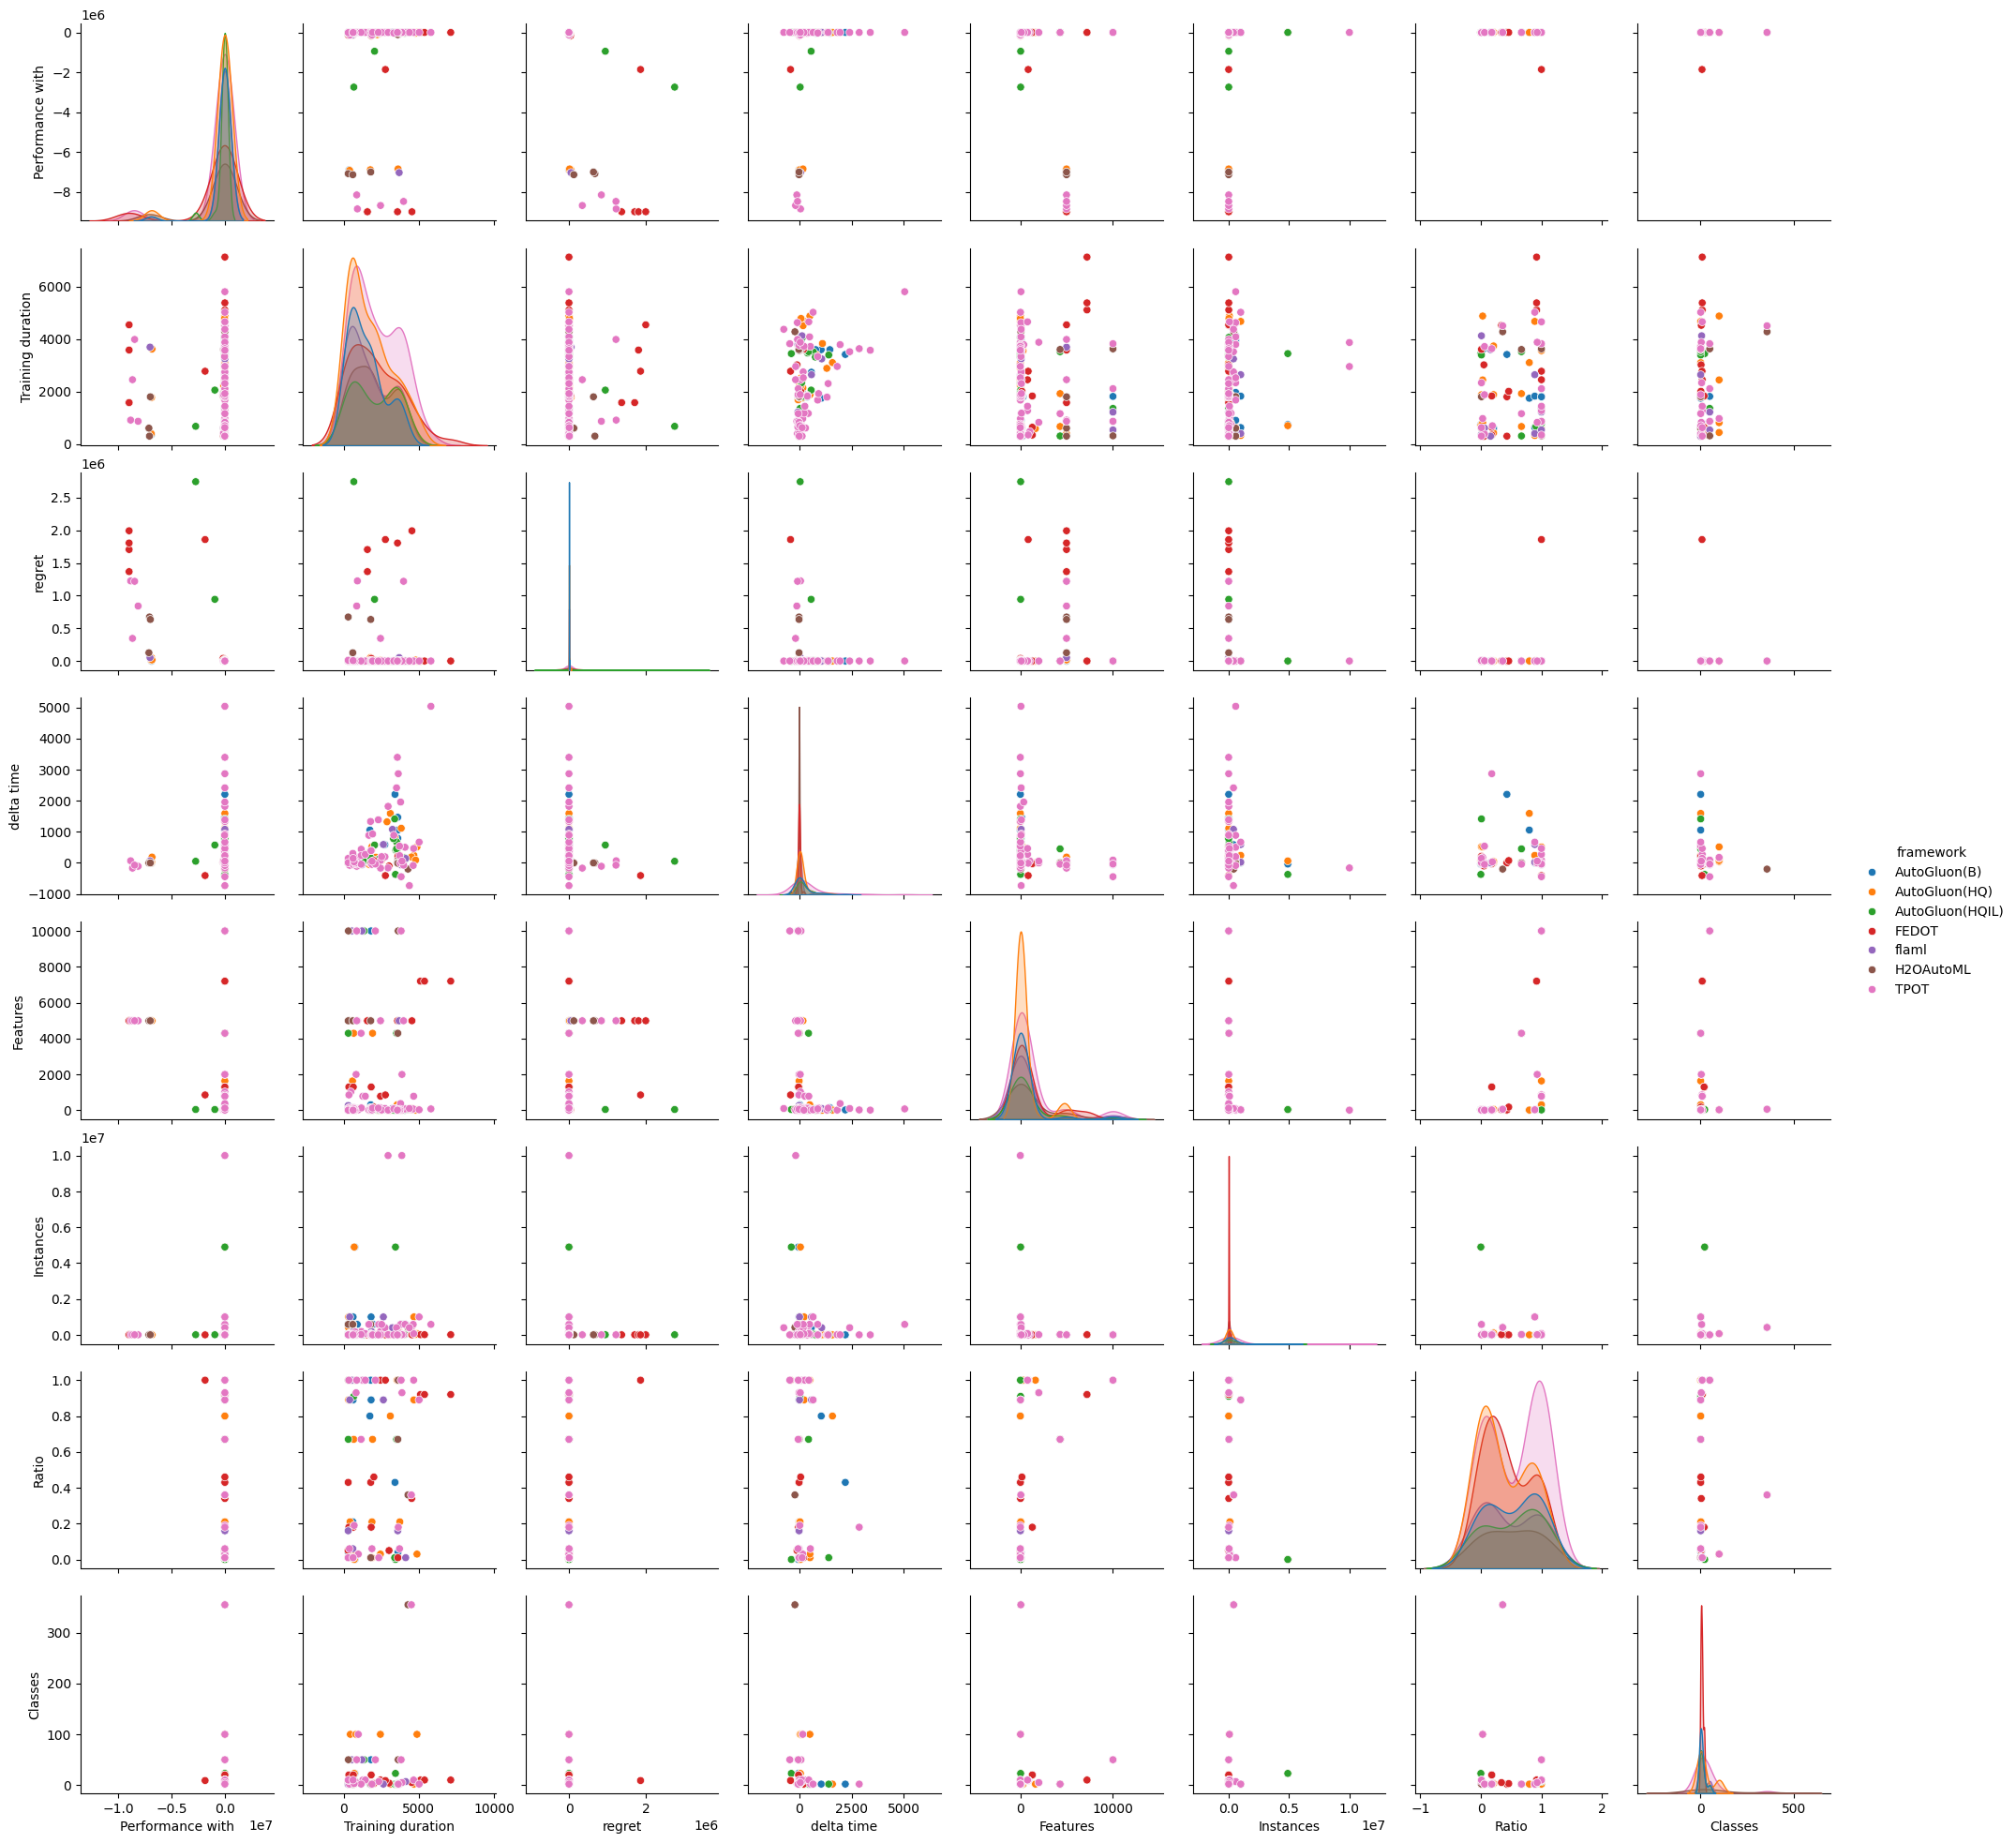

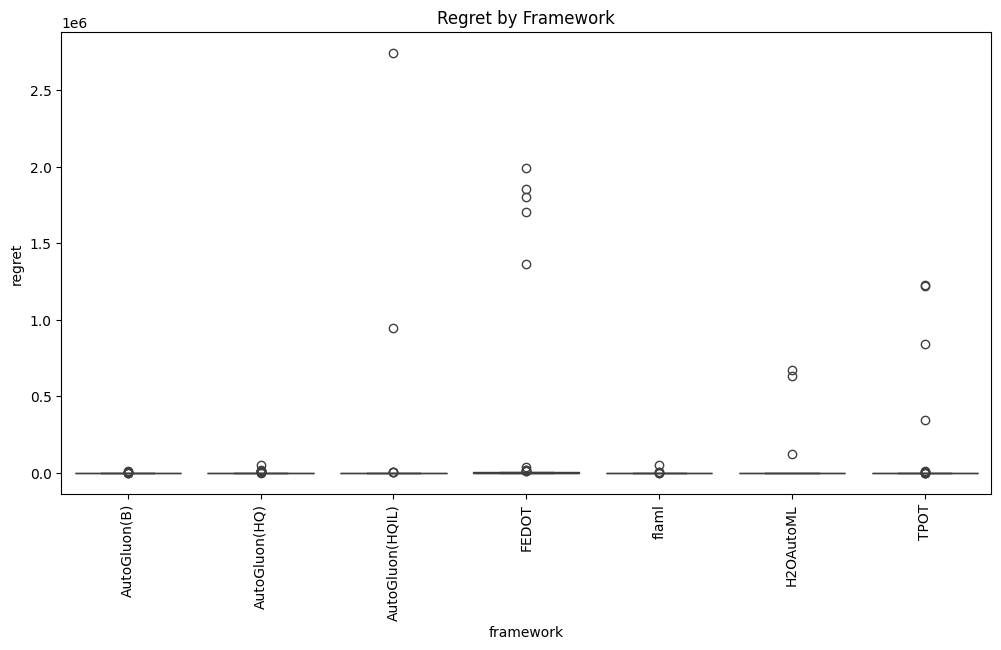

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming filtered_df_regret is already defined
# Pairplot to visualize relationships between variables
sns.pairplot(filtered_df_regret, vars=['Performance with', 'Training duration', 'regret', 'delta time', 'Features', 'Instances', 'Ratio', 'Classes'], hue='framework')
plt.show()

# Boxplot to visualize distribution of regret by framework
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_df_regret, x='framework', y='regret')
plt.xticks(rotation=90)
plt.title('Regret by Framework')
plt.show()

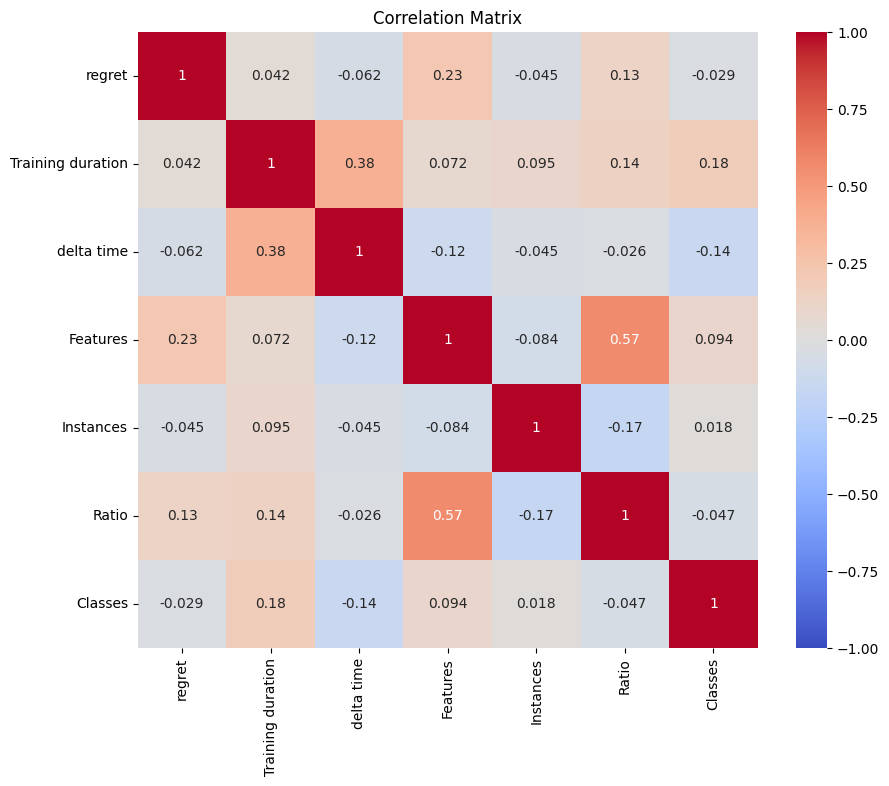

In [26]:
# Calculate correlation matrix
correlation_matrix = filtered_df_regret[['regret', 'Training duration', 'delta time', 'Features', 'Instances', 'Ratio', 'Classes']].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

### By framework

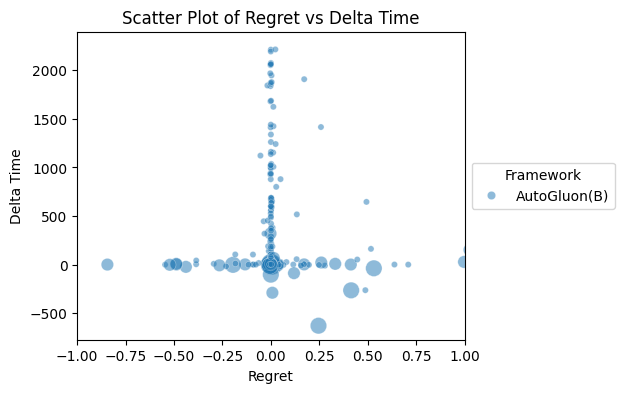

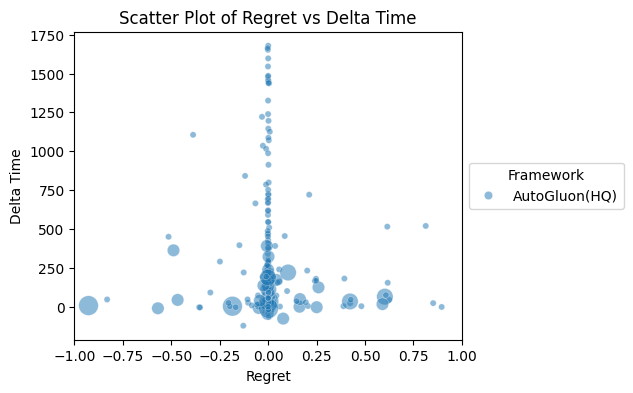

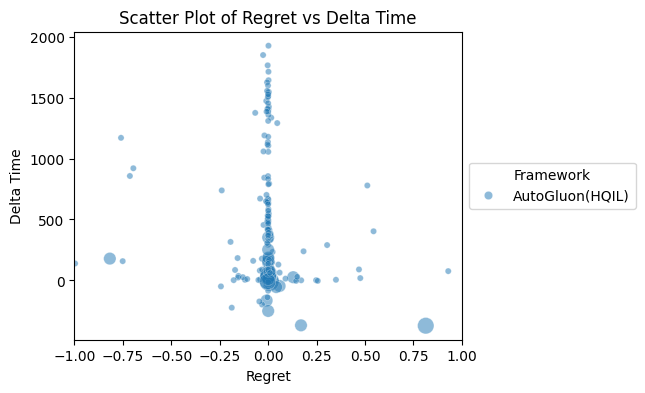

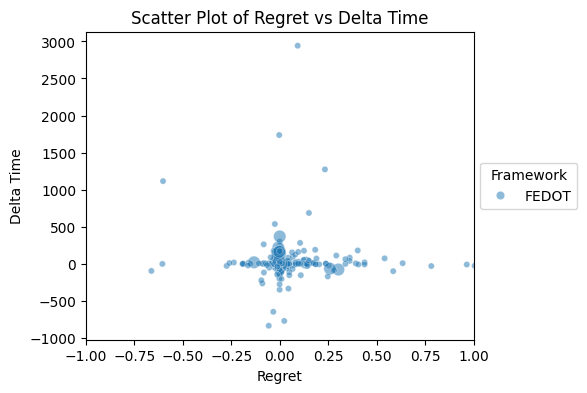

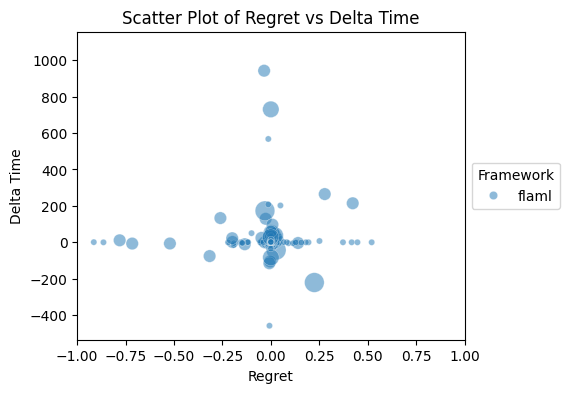

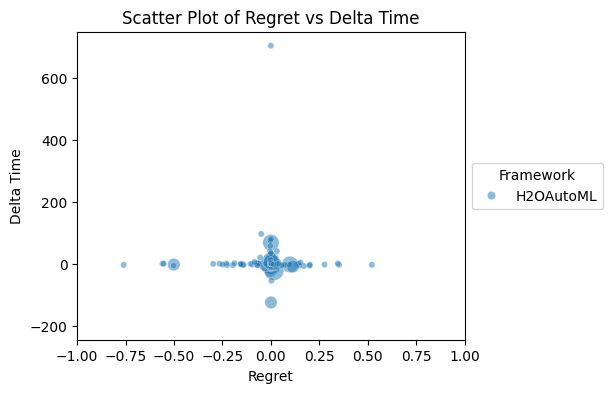

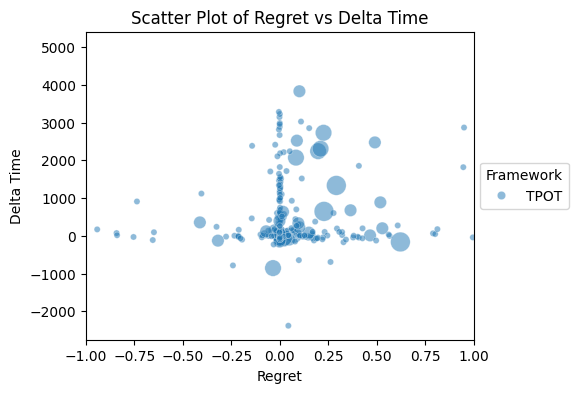

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

search_string = ['AutoGluon\\(B\\)', 'AutoGluon\\(HQ\\)', 'AutoGluon\\(HQIL\\)', 
                 'FEDOT', 'flaml', 'H2OAutoML', 'TPOT',
                ]

# List of frameworks to keep in the legend
name_frameworks = [
    'AutoGluon(B)',
    'AutoGluon(HQ)',
    'AutoGluon(HQIL)',
    'FEDOT',
    'flaml',
    'H2OAutoML',
    'TPOT'
]

for frameworks_to_keep, name in zip(search_string, name_frameworks):
    this_dataframe_with_without_early = dataframe_with_without_early[dataframe_with_without_early['framework'].str.contains(frameworks_to_keep, na=False)]  
    # Create the scatter plot
    plt.figure(figsize=(5, 4))
    scatter_plot = sns.scatterplot(x='regret', y='delta time', hue='framework', size='size', data=this_dataframe_with_without_early, alpha=0.5, sizes=(20, 200))
    
    # Set limits for the x-axis
    plt.xlim(-1, 1)
    
    # Add title and labels
    plt.title('Scatter Plot of Regret vs Delta Time')
    plt.xlabel('Regret')
    plt.ylabel('Delta Time')
    
    # Customize the legend to keep only the specified frameworks
    handles, labels = scatter_plot.get_legend_handles_labels()
    filtered_handles_labels = [(handle, label) for handle, label in zip(handles, labels) if label in name]
    
    # Add the customized legend outside the plot
    scatter_plot.legend(*zip(*filtered_handles_labels), title='Framework', loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Save the plot
    plt.savefig(FIGURE_DIRECTORY / f'regret_delta_{name}.png', bbox_inches='tight', dpi=300)
    
    # Display the plot
    plt.show()

C:\Users\20210595\AppData\Local\Temp\ipykernel_36444\2381369142.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_dataframe_with_without_early['size'] = this_dataframe_with_without_early['size']/100
C:\Users\20210595\AppData\Local\Temp\ipykernel_36444\2381369142.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_dataframe_with_without_early['size'] = this_dataframe_with_without_early['size']/100
C:\Users\20210595\AppData\Local\Temp\ipykernel_36444\2381369142.py:27: SettingWithCopyWarning: 
A 

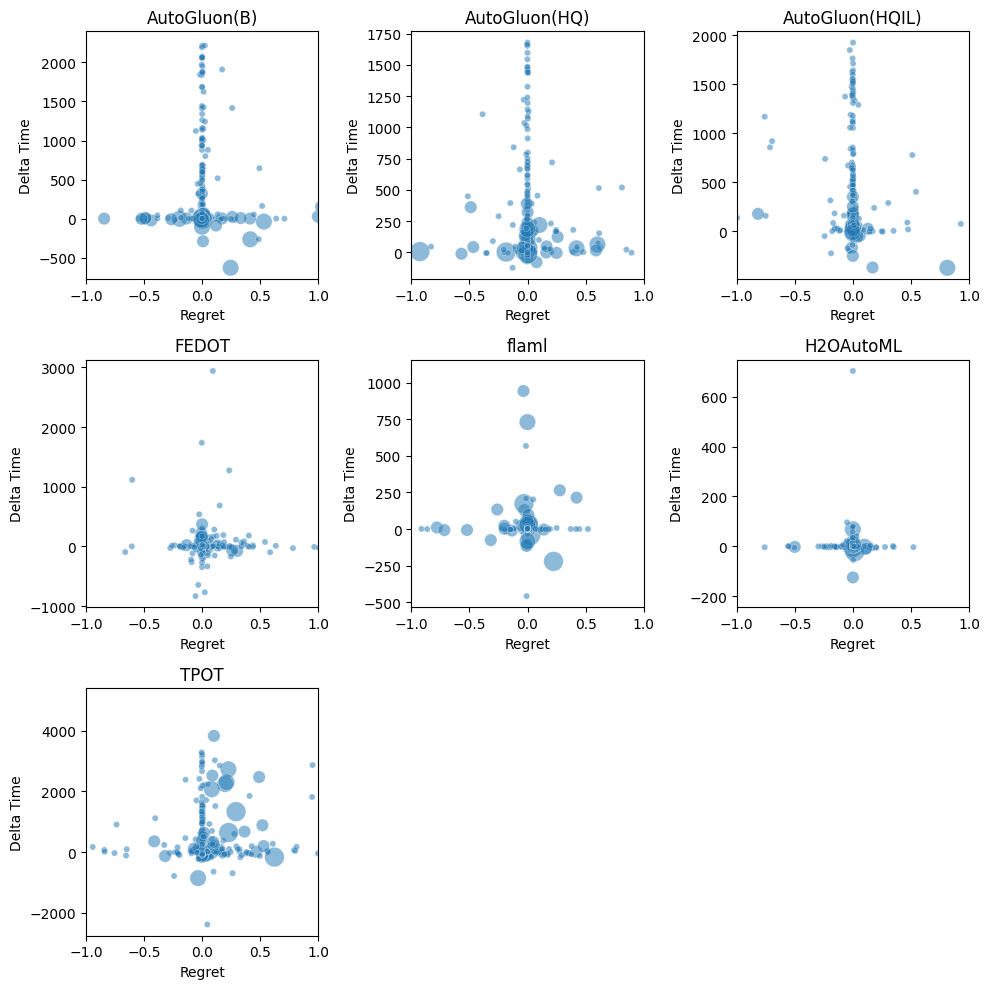

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

search_string = ['AutoGluon\\(B\\)', 'AutoGluon\\(HQ\\)', 'AutoGluon\\(HQIL\\)', 
                 'FEDOT', 'flaml', 'H2OAutoML', 'TPOT']

# List of frameworks to keep in the legend
name_frameworks = [
    'AutoGluon(B)',
    'AutoGluon(HQ)',
    'AutoGluon(HQIL)',
    'FEDOT',
    'flaml',
    'H2OAutoML',
    'TPOT'
]

# Create a figure with a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create the scatter plots
for i, (frameworks_to_keep, name) in enumerate(zip(search_string, name_frameworks)):
    this_dataframe_with_without_early = dataframe_with_without_early[dataframe_with_without_early['framework'].str.contains(frameworks_to_keep, na=False)]  
    this_dataframe_with_without_early['size'] = this_dataframe_with_without_early['size']/100
    # Create the scatter plot
    scatter_plot = sns.scatterplot(x='regret', y='delta time', hue='framework', size='size', data=this_dataframe_with_without_early, alpha=0.5, sizes=(20, 200), ax=axes[i])
    
    # Set limits for the x-axis
    axes[i].set_xlim(-1, 1)
    # axes[i].set_ylim(-2000, 4000)
    
    # Add title and labels
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Regret')
    axes[i].set_ylabel('Delta Time')
    # axes[i].set_title(f'{name}', fontsize=16)
    # axes[i].set_xlabel('Regret', fontsize=16)
    # axes[i].set_ylabel('Delta Time', fontsize=16)
    
    # Remove the legend
    axes[i].legend().remove()

# Hide the empty subplot
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(FIGURE_DIRECTORY / 'regret_delta_combined.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

#### General correlation

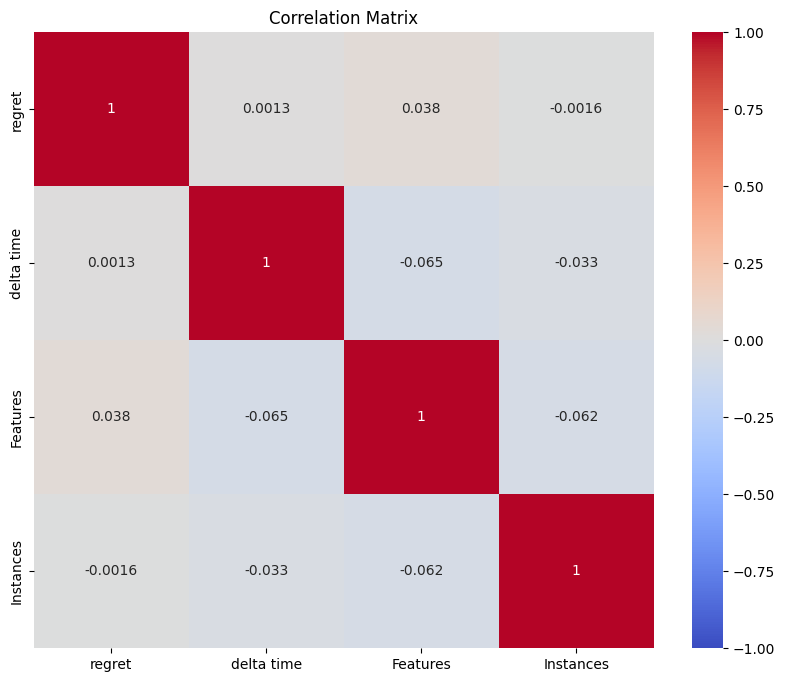

In [29]:
# Select the columns of interest
columns_of_interest = ['regret', 'delta time', 'Features', 'Instances']

# Compute the correlation matrix
correlation_matrix = dataframe_with_without_early[columns_of_interest].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#### Regression

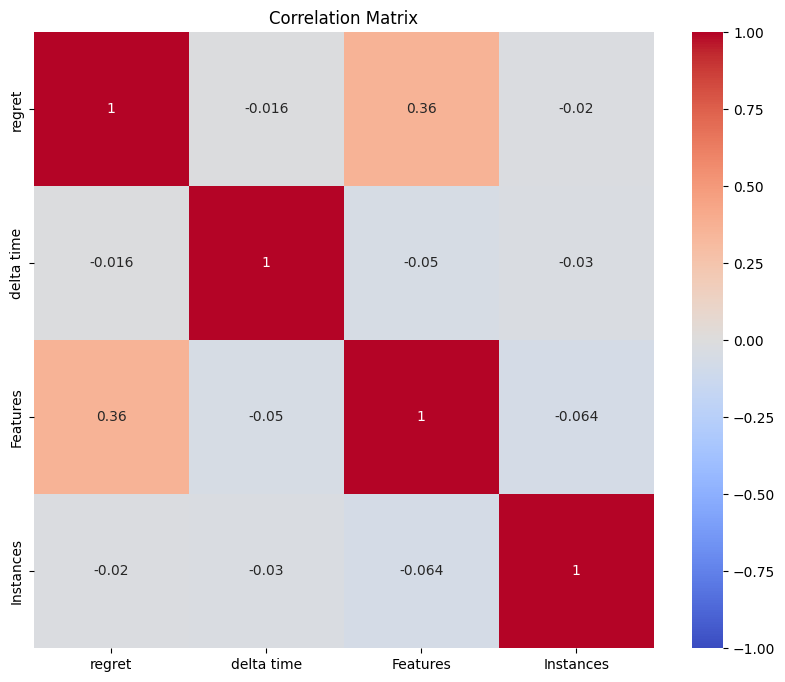

In [30]:

# Filter the DataFrame
regression_dataframe = dataframe_with_without_early[dataframe_with_without_early['task'].isin(list_regression)]

# Select the columns of interest
columns_of_interest = ['regret', 'delta time', 'Features', 'Instances']

# Compute the correlation matrix
correlation_matrix = regression_dataframe[columns_of_interest].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#### Classification

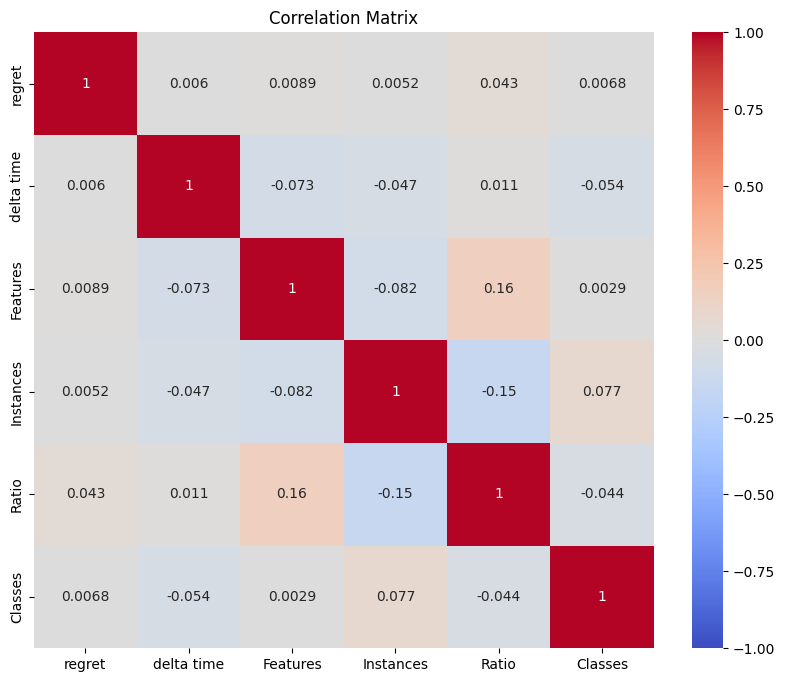

In [31]:

# Filter the DataFrame
classification_dataframe = dataframe_with_without_early[dataframe_with_without_early['task'].isin(list_multiclass + list_binary)]

# Select the columns of interest
columns_of_interest = ['regret', 'delta time', 'Features', 'Instances', 'Ratio', 'Classes']

# Compute the correlation matrix
correlation_matrix = classification_dataframe[columns_of_interest].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()